In [ ]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Andreas Horst (Technical University of Denmark)
#   Edited by: Chao Zhang (Technical University of Denmark)
#   Reviewed by: Jakob Sauer Jørgensen (DTU)

In [1]:
# Packages needed to run the code
import matplotlib.pyplot as plt
import numpy as np
import cuqi
import pywt
from scipy import sparse

In [2]:
# Set seed
np.random.seed(0)

In [3]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.7.0


# Image deblurring using Besov priors
## Andreas Horst (ahor@dtu.dk)

We consider a Linear inverse problem
\begin{equation}
Ax+\epsilon=y,
\end{equation}
where A is a convolution operator that applies periodic Gaussian blur in 2D, y is the noisy and blurry image data, x is the sharp image, and $\epsilon\sim N(0,\sigma^{2} I)$ with $\sigma>0$.

In CUQIpy we set up the 2D deblurring problem using the premade testproblem Deconvolution2D where we get the forward operator $A$ as model1, the noisy data $y$ as data1 and some additional information abut the problem, e.g. the true solution for the synthetic generated data, in probInfo1.

We illustrate the synthetic generated data and the exact solution below.

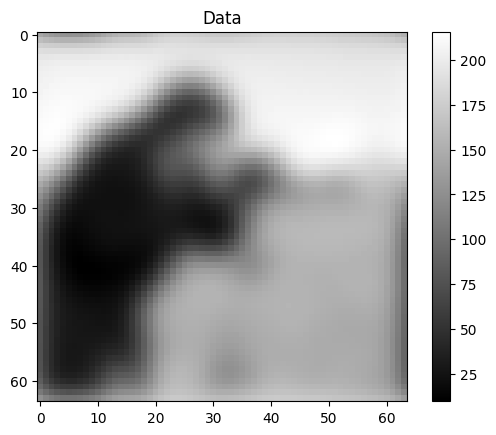

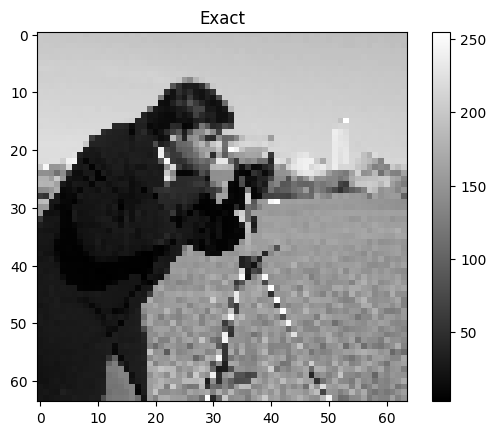

In [4]:
# Dimension of the problem as a power of 2
J=6
n = 2**J
# Noise standard deviation
sigma= 0.05
# Unpack CUQIpy testproblem
model1, data1, probInfo1 = cuqi.testproblem.Deconvolution2D(dim=n,noise_std=sigma,phantom='camera').get_components()
# Visualizing the synthetic data and the ground truth
plt.figure()
plt.imshow(data1.reshape((n,n)))
plt.set_cmap('gray')
plt.title('Data')
plt.colorbar()
plt.figure()
plt.imshow(probInfo1.exactSolution.reshape((n,n)))
plt.title('Exact')
plt.colorbar()

## Setting up the posterior

To solve the inverse problem in eq. (1) we take the Bayesian approach and seek the solution in terms of the posterior distribution given by Bayes' theorem as
\begin{equation} \tag{2}
p(x|y)\propto p(y|x)p(x).
\end{equation}
To estimate the posterior in eq. (2) we have to specify the likelihood $p(y|x)$ and the prior distribution $p(x)$.
### Defining the prior
We start by assuming that the unknown $x$ follows a 2D Besov prior 
\begin{equation} \tag{3}
x\sim \text{Besov}(s,p,\text{wavelet}, \gamma).
\end{equation}
The Besov prior is a wavelet based prior that penelizes the p-norm of the scaled wavelet coefficients of a function $f$ where the unknown $x$ is samples from $f$. The Besov prior is associated with a prior distribution given by $p(x)\propto \exp\left(-\gamma\|Bx\|_{p}^{p}\right)$, where $Bx\approx \{2^{j(s+d/2-d/p)} \langle f,\psi_{j,k} \rangle\}$ is the approximation of the scaled wavelet coefficients computed from the discrete unknown $x$.

We setup the Besov prior as a class which contains the information $s,p,\text{wavelet}, \gamma$ and contains procedure to compute $B$ and $B\bar{x}$ given some $\bar{x}$. 

Here we stress that to do the wavelet computation the package PyWavelets (pywt) must be installed.

In [5]:
class besov_prior2D:
    def __init__(self,J,delt,s=1, p=1, wavelet="db1"):
        # s paramter
        self.s = s
        # p parameter
        self.p = p
        # wavelet basis
        self.wavelet = wavelet
        # Maximum amount of wavelet levels, that is dimension n=2^(2*J).
        self.J = J
        # Prior regularization paramter
        self.delt = delt

    def weights(self):
        # Method of computing the scaling weights of the Besov prior
        # Dimension
        n = 2**(self.J*2)
        # Allocation
        inv_weights = np.zeros(n)
        # Computing scaling function weigth
        inv_weights[0] = 1
        # Computing the weights for each wavelet level.
        for i in range(self.J):
            inv_weights[2**(i*2):2**((i+1)*2)]=2**(i*(self.s+1.0-2.0/self.p))
        return inv_weights

    def wavelet_weigth(self, signal):
         # Method for computing Bx where x is the input signal
         # Computing the wavelet coefficients from discrete samples given by the signal
         wavelet_coefficients = pywt.wavedec2(signal.reshape((2**self.J,2**self.J)), self.wavelet, mode='periodization', level=self.J)
         # Putting the wavelet coefficients into a 1D array
         ravel_coefficients = pywt.ravel_coeffs(wavelet_coefficients)[0]
         # Computing the scaling weigths of the Besov prior
         weights =  1/np.sqrt(2**(self.J*2))*self.weights()
         weights[0:1] = 1/np.sqrt(2**(self.J*2))
         # Returning Bx
         return weights*ravel_coefficients
        
    def compute_besov_matrix(self):
      # Computing the Besov matrix B
        N = 2**self.J
        I0 = np.zeros((N,N))
        A = np.zeros((N**2,N**2))
        # Evaluating the linear transform on the identity matrix which provides the matrix B
        for i in range(N):
            for j in range(N):
                I0[i,j] = 1
                a_row = self.wavelet_weigth(I0.flatten()) 
                A[:,i*N+j] = a_row.flatten()
                I0[i,j] = 0 
        return sparse.csr_matrix(A)

To define the Besov prior $p(x)$ in eq. (3) in CUQIpy we use the UserDefinedDistribution where we have to supply the logpdf and its associated gradient since we want to utilize gradient based samplers.
The logpdf of the Besov prior is 
\begin{equation}\tag{4}
\log p(x)=-\gamma \|Bx\|_{p}^{p},
\end{equation}
and its gradient
\begin{equation}\tag{5}
\nabla \log p(x) = -\gamma p B^{T}\text{sign} \left(Bx\right)\left|Bx\right|^{p-1}.
\end{equation}
In this showcase we setup the prior by choosing $s=1.5, p=1.5, \gamma=1$, and the wavelet is chosen to be the Haar wavelet. With these definitions we use the Besov prior class to setup the Besov prior as a distribution in CUQIpy.


In [6]:
# Choosing the Besov parameters
s = 1.5
p = 1.5
wavelet = 'db1'
# Setting the regularization parameter
gamma = 1
# Defining the prior
prior = besov_prior2D(J,gamma,s,p,wavelet)
B_T = np.transpose(prior.compute_besov_matrix())
# Defining the logpdf and its gradient
logpdf = lambda x:-gamma*np.linalg.norm(prior.wavelet_weigth(x),ord=p)**p
gradient = lambda x:-gamma*p*B_T@(np.sign(prior.wavelet_weigth(x))*np.abs(prior.wavelet_weigth(x))**(p-1))
# Defining the Besov prior as cuqi UserDefinedDistribution
x=cuqi.distribution.UserDefinedDistribution(dim=n**2, logpdf_func=logpdf, gradient_func=gradient)

### Setting up the likelihood
With the Gaussian assumption on the noise model we also assume that the data is Gaussian
\begin{equation}\tag{6}
y\sim N(Ax,\sigma^{2}I),
\end{equation}
which leads to the likelihood as $p(y|x)\propto \exp(-\frac{1}{2\sigma^{2}}\|Ax-y\|_{2}^{2})$.
We can set up the likelihood by using CUQIpy's Gaussian distribution with mean $Ax$ and variance $\sigma^{2}$.


In [7]:
# Defining the likelihood as a CUQIpy distribution.
y = cuqi.distribution.Gaussian(model1(x),sigma**2)

### Setting up the posterior
We arrive at the posterior by combining the prior and the likelihood
\begin{equation}\tag{7}
p(x|y)\propto \exp\left(-\frac{1}{2\sigma^{2}}\|Ax-y\|_{2}^{2}-\frac{\gamma}{p}\|Bx\|_{p}^{p}\right).
\end{equation}
In CUQIpy we set up the posterior as the joint distribution of $y$ and $x$ and then condition it on the given data.

In [8]:
# Computing the joint distribution of the data and the unknown
joint = cuqi.distribution.JointDistribution(y,x)
# Setting up the posterior by conditioning on the given data.
posterior = joint(y=data1)

## Sampling and computing estimates of the posterior.
To charecterize the posterior $p(x|y)$, we sample it using Markov Chain Monte Carlo(MCMC) methods and use these samples to compute estimates, e.g., the posterior mean.

Since we have access to the gradient we choose to use the robust MCMC sampler NUTS. In CUQIpy we set up the sampler by supplying the posterior to the NUTS sampling class.

In [9]:
sampler = cuqi.sampler.NUTS(posterior)

We choose to do 2000 samples using a burn-in period of 20% so 400 burn-in samples.

In [10]:
samples = sampler.sample_adapt(2000,400)

Sample 2400 / 2400


We plot some of the sample chains to access the quality of the samples.

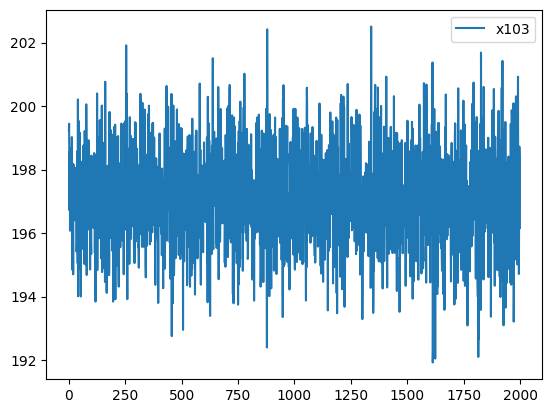

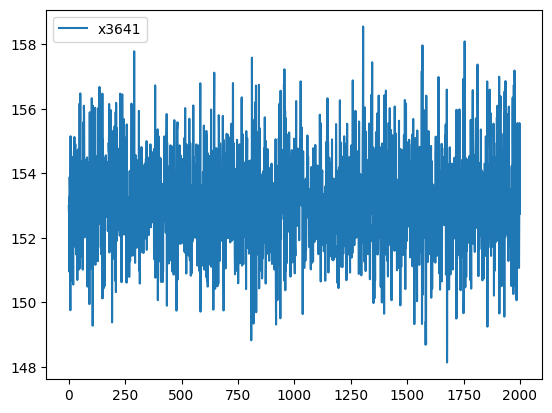

In [11]:
plt.figure()
samples.plot_chain(103)
plt.figure()
samples.plot_chain(3641)

The above chains seems to be well mixed and oscillating around a near constant value so they appear to have converged by visual inspection.

To determine if the samples are correlated we check the autocorrelation function of the chosen samples

array([<Axes: title={'center': 'x103'}>,
       <Axes: title={'center': 'x3641'}>], dtype=object)

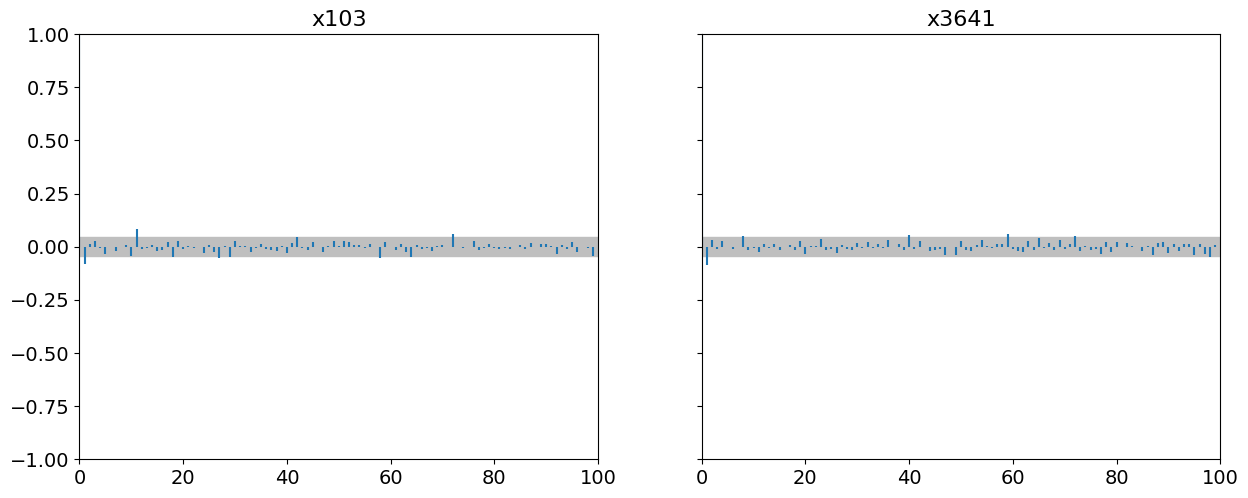

In [12]:
samples.plot_autocorrelation([103,3641])

The autocorrelation function is within the significance bounds so the samples is close to uncorrelated.

To estimate the posterior, we compute the posterior mean from the samples and show the pixelwise mean below. Observe the blockiness imposed by the prior.

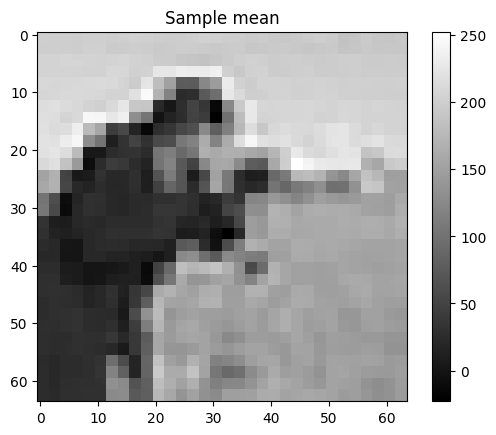

In [13]:
samples.plot_mean()
plt.colorbar()

To visualize the posterior uncertainty we plot the pixelwise width of the $95\%$ posterior credible interval

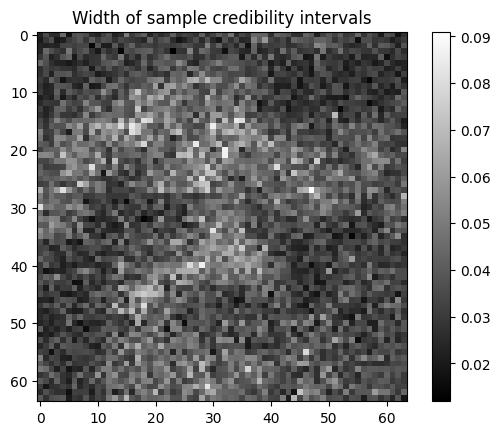

In [14]:
samples.plot_ci_width(0.95)
plt.colorbar()